
# 🥖 TGTG — Fast Simulation Notebook (Scenario Sweeps + Robust Answers)

This notebook uses the compiled simulator in `tgtg_fast.py` to run **many scenarios quickly**, **parallelise** evaluations, and generate evidence for two research questions:

1) **Does TGTG increase or decrease production?**  
   - Tested **robustly** across *different stochastic demand specifications*.

2) **How do basic hyperparameters shift outcomes?**  
   - number of goods \(L\)  
   - relative prices / margins (\(
ho/\chi\), \(	au/
ho\))  
   - volatility & persistence of demand (Beta concentration or AR(1) logit volatility)

**What you get out**
- A clean *baseline vs TGTG* comparison of **production**, **waste**, and **profit**.
- A sweep over hyperparameters with visualizations of **Δ production** and **Δ waste**.

---

## Assumptions & mapping to your model
- Regular sales occur at unit price \(
ho\).
- TGTG sales are modelled as **per-unit salvage price** \(	au\) on the reserved share \(b\).
  - If you instead want “bags” of size \(k\) sold at price \(	au\) per bag, see the note at the end (small change).
- Baker chooses:
  - production vector \(q \in \mathbb{Z}_{\ge 0}^L\)
  - reserved share \(b \in [0,1]\)
- Fitness is risk-adjusted profit across days:
  \[
  	ext{fitness}=D(ar{\pi}-\gamma \sigma_{\pi})
  \]
- Demand is via **visit probability** \(lpha_t\) per day (stochastic path).

> Tip: run the notebook top-to-bottom once to compile Numba, then scenario sweeps become much faster.


In [1]:

# If you placed tgtg_fast.py in the same folder as this notebook, this works.
# In this environment it's in /mnt/data; we add that to sys.path.

import sys
from pathlib import Path

sys.path.append("/mnt/data")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor, as_completed
import os
import time

from tgtg_fast import (
    EnvironmentConfig, BakerAgent,
    generate_preferences,
    make_common_random_draws,
    alpha_path_constant, alpha_path_beta_shocks, alpha_path_logit_ar1,
    simulate_epoch_fast
)

np.set_printoptions(suppress=True)



## 1) Core helpers: evaluation, evolutionary optimizer, and out-of-sample testing

We use a lightweight evolutionary optimizer to approximate the baker’s best-response (optimal \(q\) and \(b\)).  
This is modular so you can later swap in Bayesian optimisation / CMA-ES / etc.

### Why common random numbers?
At each generation we evaluate all candidates on the **same** random draws (`perm`, `visit_u`, `walk_u`) so selection is less noisy and results are more stable.


In [2]:

def clip_agent(agent: BakerAgent, q_max: int) -> BakerAgent:
    q = np.clip(np.floor(agent.q), 0, q_max).astype(np.int64)
    b = float(np.clip(agent.b, 0.0, 1.0))
    return BakerAgent(q=q, b=b, gamma=float(agent.gamma))


def init_population(P: int, L: int, gamma: float, q_max: int, rng: np.random.Generator) -> list[BakerAgent]:
    pop = []
    for _ in range(P):
        q = rng.integers(low=0, high=q_max + 1, size=L, dtype=np.int64)
        b = rng.random()
        pop.append(BakerAgent(q=q, b=float(b), gamma=float(gamma)))
    return pop


def mutate(agent: BakerAgent, q_sigma: float, b_sigma: float, q_max: int, rng: np.random.Generator) -> BakerAgent:
    q = agent.q.astype(np.float64) + rng.normal(0.0, q_sigma, size=agent.q.shape[0])
    b = agent.b + float(rng.normal(0.0, b_sigma))
    child = BakerAgent(q=q, b=b, gamma=agent.gamma)
    return clip_agent(child, q_max=q_max)


def evaluate_population_parallel(
    population: list[BakerAgent],
    prefs: np.ndarray,
    env: EnvironmentConfig,
    alpha_path: np.ndarray,
    perm: np.ndarray,
    visit_u: np.ndarray,
    walk_u: np.ndarray,
    max_workers: int | None = None
) -> tuple[np.ndarray, list[dict]]:
    """Parallel evaluation of the population using threads."""
    if max_workers is None:
        max_workers = max(1, os.cpu_count() or 1)

    metrics_list = [None] * len(population)

    def _eval_one(idx: int):
        m = simulate_epoch_fast(population[idx], prefs, env, alpha_path, perm, visit_u, walk_u)
        return idx, m

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = [ex.submit(_eval_one, i) for i in range(len(population))]
        for f in as_completed(futures):
            idx, m = f.result()
            metrics_list[idx] = m

    fitness = np.array([m["fitness"] for m in metrics_list], dtype=np.float64)
    return fitness, metrics_list


def evolutionary_optimize(
    env: EnvironmentConfig,
    demand_spec: dict,
    *,
    gamma: float = 0.8,
    allow_tgtg: bool = True,
    preference_mode: str = "random",
    seed: int = 0,
    D: int = 30,
    P: int = 80,
    G: int = 30,
    elite_frac: float = 0.20,
    q_max: int = 120,
    q_sigma: float = 10.0,
    b_sigma: float = 0.08,
    n_workers: int | None = None,
) -> dict:
    """
    demand_spec examples:
      {"kind":"constant", "alpha":0.35}
      {"kind":"beta", "alpha_mean":0.35, "concentration":20.0}
      {"kind":"ar1", "alpha0":0.35, "phi":0.8, "sigma":0.6}
    """
    rng = np.random.default_rng(seed)

    prefs = generate_preferences(env.N, env.L, mode=preference_mode, rng=rng)

    pop = init_population(P, env.L, gamma=gamma, q_max=q_max, rng=rng)
    if not allow_tgtg:
        for a in pop:
            a.b = 0.0

    elite_n = max(2, int(P * elite_frac))
    history = []

    def make_alpha_path(rng_local: np.random.Generator) -> np.ndarray:
        k = demand_spec["kind"]
        if k == "constant":
            return alpha_path_constant(D, demand_spec["alpha"])
        if k == "beta":
            return alpha_path_beta_shocks(D, demand_spec["alpha_mean"], demand_spec["concentration"], rng_local)
        if k == "ar1":
            return alpha_path_logit_ar1(D, demand_spec["alpha0"], demand_spec["phi"], demand_spec["sigma"], rng_local)
        raise ValueError(f"Unknown demand spec kind: {k}")

    best_agent = None
    best_fit = -1e18
    best_metrics = None

    # Warm-up compile once
    perm0, visit0, walk0 = make_common_random_draws(D, env.N, env.L, seed=seed + 10_000)
    alpha0 = make_alpha_path(np.random.default_rng(seed + 20_000))
    _ = simulate_epoch_fast(pop[0], prefs, env, alpha0, perm0, visit0, walk0)

    for g in range(G):
        perm, visit_u, walk_u = make_common_random_draws(D, env.N, env.L, seed=seed + 1_000_000 + g)
        alpha_path = make_alpha_path(np.random.default_rng(seed + 2_000_000 + g))

        fitness, metrics_list = evaluate_population_parallel(
            pop, prefs, env, alpha_path, perm, visit_u, walk_u, max_workers=n_workers
        )

        order = np.argsort(fitness)[::-1]
        elites = [pop[i] for i in order[:elite_n]]
        elite_metrics = [metrics_list[i] for i in order[:elite_n]]

        if float(fitness[order[0]]) > best_fit:
            best_fit = float(fitness[order[0]])
            best_agent = elites[0]
            best_metrics = elite_metrics[0]

        history.append({
            "gen": g,
            "best_fitness": float(fitness[order[0]]),
            "mean_fitness": float(np.mean(fitness)),
            "best_production": float(metrics_list[order[0]]["production"]),
            "best_waste": float(metrics_list[order[0]]["waste"]),
            "best_b": float(pop[order[0]].b),
        })

        new_pop = elites.copy()
        while len(new_pop) < P:
            parent = elites[rng.integers(0, elite_n)]
            child = mutate(parent, q_sigma=q_sigma, b_sigma=b_sigma, q_max=q_max, rng=rng)
            if not allow_tgtg:
                child.b = 0.0
            new_pop.append(child)
        pop = new_pop

    return {
        "best_agent": best_agent,
        "best_fit": best_fit,
        "best_metrics_train": best_metrics,
        "prefs": prefs,
        "history": pd.DataFrame(history),
        "env": env,
        "demand_spec": demand_spec,
        "seed": seed,
        "D": D,
    }


def out_of_sample_eval(
    agent: BakerAgent,
    prefs: np.ndarray,
    env: EnvironmentConfig,
    demand_spec: dict,
    *,
    seed: int,
    D: int = 30,
    reps: int = 30
) -> pd.DataFrame:
    def make_alpha_path(rng_local: np.random.Generator) -> np.ndarray:
        k = demand_spec["kind"]
        if k == "constant":
            return alpha_path_constant(D, demand_spec["alpha"])
        if k == "beta":
            return alpha_path_beta_shocks(D, demand_spec["alpha_mean"], demand_spec["concentration"], rng_local)
        if k == "ar1":
            return alpha_path_logit_ar1(D, demand_spec["alpha0"], demand_spec["phi"], demand_spec["sigma"], rng_local)
        raise ValueError(f"Unknown demand spec kind: {k}")

    rows = []
    for j in range(reps):
        perm, visit_u, walk_u = make_common_random_draws(D, env.N, env.L, seed=seed + 100_000 + j)
        alpha_path = make_alpha_path(np.random.default_rng(seed + 200_000 + j))
        m = simulate_epoch_fast(agent, prefs, env, alpha_path, perm, visit_u, walk_u)
        m = dict(m)
        m["rep"] = j
        rows.append(m)
    return pd.DataFrame(rows)



## 2) Single-scenario: baseline vs TGTG across multiple demand specs

We compare:
- **Baseline**: force \(b=0\) (no TGTG)
- **TGTG**: optimise both \(q\) and \(b\)

and we do this across different stochastic demand specs for robustness.


In [ ]:

env0 = EnvironmentConfig(
    N=600, # number of consumers
    L=6,
    r=0.35,
    chi=1.0,
    rho=2.5,
    tau=0.8
)
gamma0 = 0.8
D0 = 30

demand_specs = [
    {"kind":"constant", "alpha":0.35, "label":"constant α=0.35"},
    {"kind":"beta", "alpha_mean":0.35, "concentration":20.0, "label":"beta shocks (conc=20)"},
    {"kind":"beta", "alpha_mean":0.35, "concentration":5.0, "label":"beta shocks (conc=5, high vol)"},
    {"kind":"ar1", "alpha0":0.35, "phi":0.8, "sigma":0.6, "label":"logit-AR1 (φ=0.8, σ=0.6)"},
]

# Optimiser budget
P = 500 # population size
G = 50 # generations

seed_base = 42


In [4]:

results = []
trained = {}

t0 = time.time()

for k, spec in enumerate(demand_specs):
    print(f"\n=== Demand spec: {spec['label']} ===")

    out_tgtg = evolutionary_optimize(
        env0, spec,
        gamma=gamma0, allow_tgtg=True,
        preference_mode="correlated",
        seed=seed_base + 10*k,
        D=D0, P=P, G=G,
        n_workers=None
    )

    out_base = evolutionary_optimize(
        env0, spec,
        gamma=gamma0, allow_tgtg=False,
        preference_mode="correlated",
        seed=seed_base + 10*k,
        D=D0, P=P, G=G,
        n_workers=None
    )

    trained[(spec["label"], "tgtg")] = out_tgtg
    trained[(spec["label"], "base")] = out_base

    oos_tgtg = out_of_sample_eval(out_tgtg["best_agent"], out_tgtg["prefs"], env0, spec, seed=seed_base + 10*k + 1, D=D0, reps=25)
    oos_base = out_of_sample_eval(out_base["best_agent"], out_base["prefs"], env0, spec, seed=seed_base + 10*k + 1, D=D0, reps=25)

    def summarize(df):
        return {
            "production_mean": df["production"].mean(),
            "waste_mean": df["waste"].mean(),
            "profit_mean": df["mean_profit"].mean(),
        }

    s_t = summarize(oos_tgtg)
    s_b = summarize(oos_base)

    results.append({
        "demand_spec": spec["label"],
        "prod_base": s_b["production_mean"],
        "prod_tgtg": s_t["production_mean"],
        "delta_prod": s_t["production_mean"] - s_b["production_mean"],
        "waste_base": s_b["waste_mean"],
        "waste_tgtg": s_t["waste_mean"],
        "delta_waste": s_t["waste_mean"] - s_b["waste_mean"],
        "profit_base": s_b["profit_mean"],
        "profit_tgtg": s_t["profit_mean"],
        "delta_profit": s_t["profit_mean"] - s_b["profit_mean"],
        "b_star_tgtg": float(out_tgtg["best_agent"].b),
        "prod_per_day_tgtg": s_t["production_mean"]/D0,
        "prod_per_day_base": s_b["production_mean"]/D0,
    })

elapsed = time.time() - t0
print(f"\nDone in {elapsed:.1f}s")
df_comp = pd.DataFrame(results).sort_values("delta_prod", ascending=False)
df_comp



=== Demand spec: constant α=0.35 ===

=== Demand spec: beta shocks (conc=20) ===

=== Demand spec: beta shocks (conc=5, high vol) ===

=== Demand spec: logit-AR1 (φ=0.8, σ=0.6) ===

Done in 10.7s


,demand_spec,prod_base,prod_tgtg,delta_prod,waste_base,waste_tgtg,delta_waste,profit_base,profit_tgtg,delta_profit,b_star_tgtg,prod_per_day_tgtg,prod_per_day_base
0,constant α=0.35,5550.0,5790.0,240.0,73.12,65.28,-7.84,271.406667,268.760000,-2.646667,0.048094,193.0,185.0
2,"beta shocks (conc=5, high vol)",5160.0,5340.0,180.0,1026.76,1106.40,79.64,172.436667,174.800000,2.363333,0.000000,178.0,172.0
1,beta shocks (conc=20),5370.0,5250.0,-120.0,452.80,391.52,-61.28,230.766667,229.873333,-0.893333,0.000000,175.0,179.0
3,"logit-AR1 (φ=0.8, σ=0.6)",6390.0,5850.0,-540.0,879.84,599.80,-280.04,246.180000,242.516667,-3.663333,0.000000,195.0,213.0


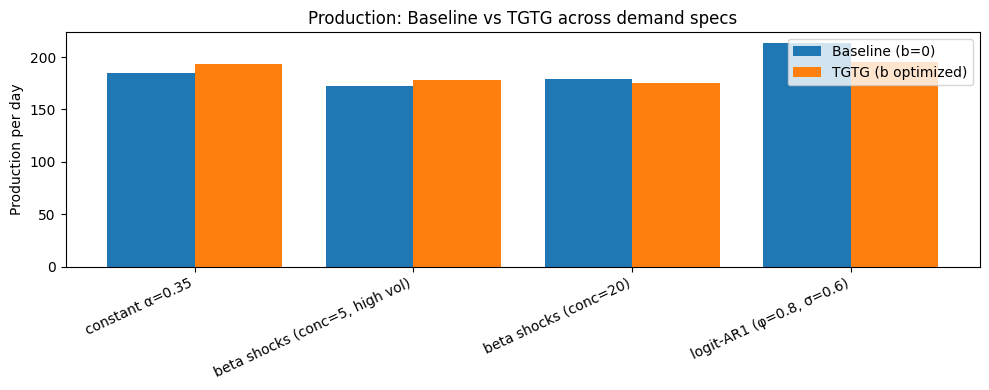

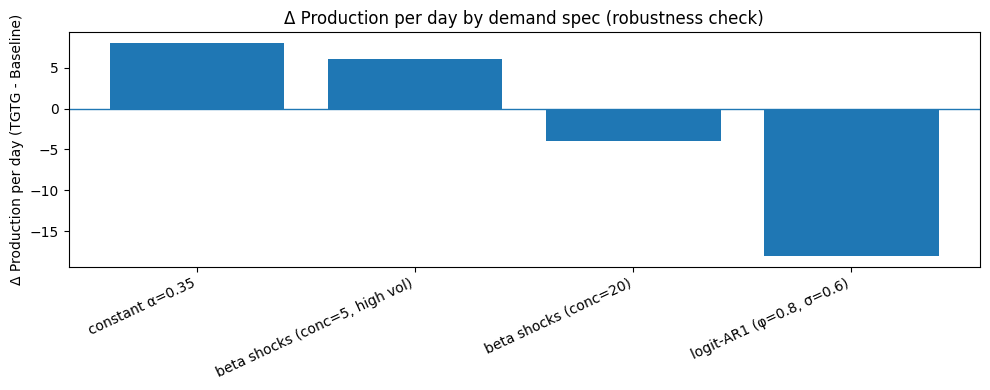

In [5]:

# Visual answer to Q1: does TGTG increase or decrease production? (by demand spec)

fig, ax = plt.subplots(figsize=(10, 4))
x = np.arange(len(df_comp))
ax.bar(x - 0.2, df_comp["prod_base"]/D0, width=0.4, label="Baseline (b=0)")
ax.bar(x + 0.2, df_comp["prod_tgtg"]/D0, width=0.4, label="TGTG (b optimized)")
ax.set_xticks(x)
ax.set_xticklabels(df_comp["demand_spec"], rotation=25, ha="right")
ax.set_ylabel("Production per day")
ax.set_title("Production: Baseline vs TGTG across demand specs")
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
ax.axhline(0, linewidth=1)
ax.bar(x, df_comp["delta_prod"]/D0)
ax.set_xticks(x)
ax.set_xticklabels(df_comp["demand_spec"], rotation=25, ha="right")
ax.set_ylabel("Δ Production per day (TGTG - Baseline)")
ax.set_title("Δ Production per day by demand spec (robustness check)")
plt.tight_layout()
plt.show()


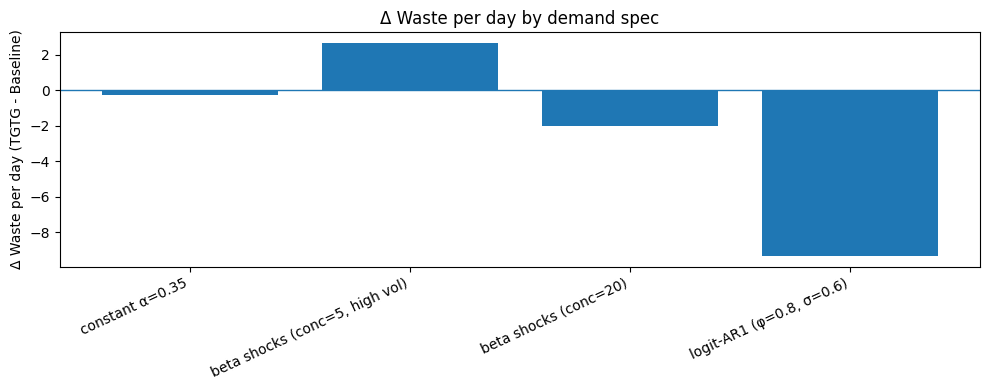

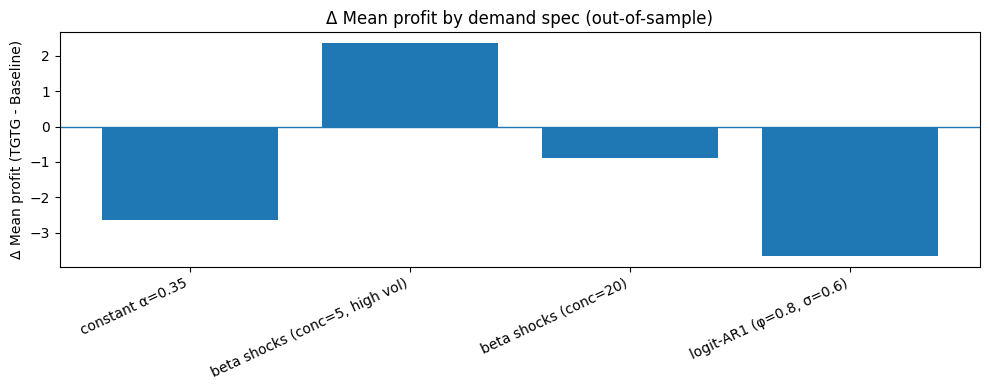

In [6]:

# Supporting evidence: waste & profit effects

fig, ax = plt.subplots(figsize=(10, 4))
ax.axhline(0, linewidth=1)
ax.bar(x, df_comp["delta_waste"]/D0)
ax.set_xticks(x)
ax.set_xticklabels(df_comp["demand_spec"], rotation=25, ha="right")
ax.set_ylabel("Δ Waste per day (TGTG - Baseline)")
ax.set_title("Δ Waste per day by demand spec")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
ax.axhline(0, linewidth=1)
ax.bar(x, df_comp["delta_profit"])
ax.set_xticks(x)
ax.set_xticklabels(df_comp["demand_spec"], rotation=25, ha="right")
ax.set_ylabel("Δ Mean profit (TGTG - Baseline)")
ax.set_title("Δ Mean profit by demand spec (out-of-sample)")
plt.tight_layout()
plt.show()



## 3) Hyperparameter sweeps (Q2)

We vary:
- \(L\) (number of goods)
- margins via \(
ho/\chi\) and discount via \(	au/
ho\)
- demand volatility (Beta concentration)

We record:
- optimal reserved share \(b^\*\)
- Δ production (TGTG - baseline)
- Δ waste


In [7]:

# Sweep configuration (modest defaults for interactive use)

SWEEP_L = [3, 6, 10]
MARGINS = [1.8, 2.5, 3.2]      # rho = margin * chi
DISCOUNTS = [0.2, 0.35, 0.5]   # tau = discount * rho
BETA_CONC = [5.0, 20.0, 100.0] # smaller => more volatile demand

N_sweep = 500
r_sweep = 0.35
chi_sweep = 1.0

P_sweep = 60
G_sweep = 22
D_sweep = 25
oos_reps = 15

seed_sweep = 2025


In [8]:

def run_one_sweep_point(args) -> dict:
    L, margin, disc, conc, idx = args

    env = EnvironmentConfig(
        N=N_sweep, L=L, r=r_sweep,
        chi=chi_sweep, rho=margin*chi_sweep, tau=disc*(margin*chi_sweep)
    )

    spec = {"kind":"beta", "alpha_mean":0.35, "concentration":conc, "label": f"beta(conc={conc})"}

    out_t = evolutionary_optimize(env, spec, gamma=gamma0, allow_tgtg=True,
                                 preference_mode="correlated",
                                 seed=seed_sweep + 1000*idx + 1,
                                 D=D_sweep, P=P_sweep, G=G_sweep, n_workers=None)

    out_b = evolutionary_optimize(env, spec, gamma=gamma0, allow_tgtg=False,
                                 preference_mode="correlated",
                                 seed=seed_sweep + 1000*idx + 1,
                                 D=D_sweep, P=P_sweep, G=G_sweep, n_workers=None)

    oos_t = out_of_sample_eval(out_t["best_agent"], out_t["prefs"], env, spec, seed=seed_sweep + 1000*idx + 2, D=D_sweep, reps=oos_reps)
    oos_b = out_of_sample_eval(out_b["best_agent"], out_b["prefs"], env, spec, seed=seed_sweep + 1000*idx + 2, D=D_sweep, reps=oos_reps)

    row = {
        "L": L,
        "margin_rho_over_chi": margin,
        "discount_tau_over_rho": disc,
        "beta_concentration": conc,
        "b_star": float(out_t["best_agent"].b),
        "prod_base": oos_b["production"].mean(),
        "prod_tgtg": oos_t["production"].mean(),
        "delta_prod": oos_t["production"].mean() - oos_b["production"].mean(),
        "waste_base": oos_b["waste"].mean(),
        "waste_tgtg": oos_t["waste"].mean(),
        "delta_waste": oos_t["waste"].mean() - oos_b["waste"].mean(),
        "profit_base": oos_b["mean_profit"].mean(),
        "profit_tgtg": oos_t["mean_profit"].mean(),
        "delta_profit": oos_t["mean_profit"].mean() - oos_b["mean_profit"].mean(),
    }
    return row


points = []
idx = 0
for L in SWEEP_L:
    for m in MARGINS:
        for d in DISCOUNTS:
            for c in BETA_CONC:
                points.append((L, m, d, c, idx))
                idx += 1

len(points)


81

In [9]:

# Run sweep (parallel)

max_workers = max(1, os.cpu_count() or 1)
print("max_workers:", max_workers)

t0 = time.time()
rows = []

with ThreadPoolExecutor(max_workers=max_workers) as ex:
    futures = [ex.submit(run_one_sweep_point, p) for p in points]
    for j, f in enumerate(as_completed(futures), 1):
        rows.append(f.result())
        if j % 5 == 0:
            print(f"{j}/{len(points)} done")

df_sweep = pd.DataFrame(rows)
elapsed = time.time() - t0
print(f"Completed sweep in {elapsed/60:.1f} min")
df_sweep.head()


max_workers: 8
5/81 done
10/81 done
15/81 done
20/81 done
25/81 done
30/81 done
35/81 done
40/81 done
45/81 done
50/81 done
55/81 done
60/81 done
65/81 done
70/81 done
75/81 done
80/81 done
Completed sweep in 1.5 min


,L,margin_rho_over_chi,discount_tau_over_rho,beta_concentration,b_star,prod_base,prod_tgtg,delta_prod,waste_base,waste_tgtg,delta_waste,profit_base,profit_tgtg,delta_profit
0,3,1.8,0.50,5.0,0.098130,1875.0,1500.0,-375.0,131.400000,62.133333,-69.266667,50.5392,39.0264,-11.5128
1,3,1.8,0.35,20.0,0.000000,3350.0,3350.0,0.0,168.400000,171.666667,3.266667,95.0752,94.8400,-0.2352
2,3,1.8,0.50,20.0,0.166759,3050.0,3725.0,675.0,65.866667,79.133333,13.266667,92.8576,91.9024,-0.9552
3,3,1.8,0.35,100.0,0.000000,3825.0,3900.0,75.0,110.466667,136.533333,26.066667,114.4464,114.9696,0.5232
4,3,1.8,0.20,20.0,0.000000,3275.0,3225.0,-50.0,140.400000,129.400000,-11.000000,94.6912,93.8832,-0.8080


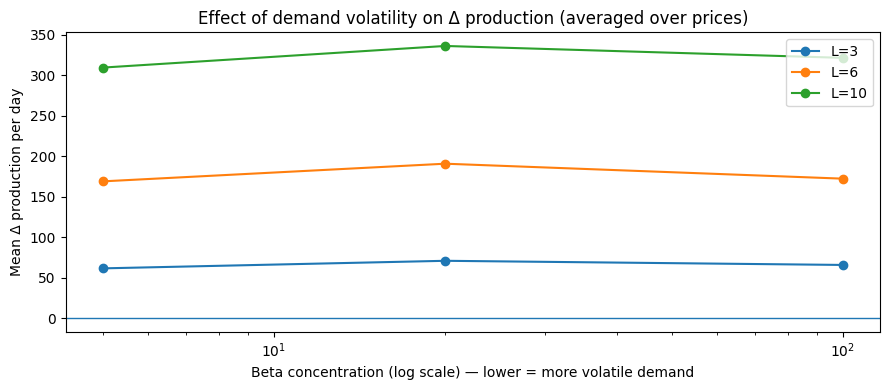

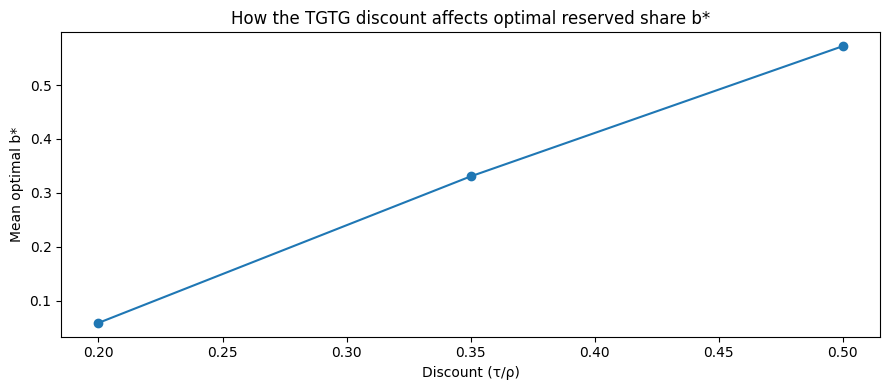

In [10]:

# Visualise: demand volatility -> Δ production (averaged over prices), grouped by L

df_sweep2 = df_sweep.copy()
df_sweep2["delta_prod_per_day"] = df_sweep2["delta_prod"] / D_sweep
df_sweep2["delta_waste_per_day"] = df_sweep2["delta_waste"] / D_sweep

fig, ax = plt.subplots(figsize=(9, 4))
for L in sorted(df_sweep2["L"].unique()):
    sub = df_sweep2[df_sweep2["L"] == L].groupby("beta_concentration")["delta_prod_per_day"].mean().reset_index()
    ax.plot(sub["beta_concentration"], sub["delta_prod_per_day"], marker="o", label=f"L={L}")
ax.set_xscale("log")
ax.axhline(0, linewidth=1)
ax.set_xlabel("Beta concentration (log scale) — lower = more volatile demand")
ax.set_ylabel("Mean Δ production per day")
ax.set_title("Effect of demand volatility on Δ production (averaged over prices)")
ax.legend()
plt.tight_layout()
plt.show()

# b* vs discount τ/ρ
fig, ax = plt.subplots(figsize=(9, 4))
sub = df_sweep2.groupby("discount_tau_over_rho")["b_star"].mean().reset_index()
ax.plot(sub["discount_tau_over_rho"], sub["b_star"], marker="o")
ax.set_xlabel("Discount (τ/ρ)")
ax.set_ylabel("Mean optimal b*")
ax.set_title("How the TGTG discount affects optimal reserved share b*")
plt.tight_layout()
plt.show()


In [11]:

# Quick "microeconomic indications": grouped summaries you can quote in text

summary = (
    df_sweep2
    .groupby(["L", "beta_concentration"])[["delta_prod_per_day", "delta_waste_per_day", "b_star", "delta_profit"]]
    .mean()
    .reset_index()
    .sort_values(["L", "beta_concentration"])
)
summary


,L,beta_concentration,delta_prod_per_day,delta_waste_per_day,b_star,delta_profit
0,3,5.0,61.777778,-5.197333,0.228062,15.541437
1,3,20.0,71.111111,-0.284148,0.216736,20.401659
2,3,100.0,66.000000,-0.282963,0.188281,20.646474
3,6,5.0,169.000000,-3.157630,0.340172,50.793422
4,6,20.0,190.777778,0.343704,0.295072,61.638681
5,6,100.0,172.333333,-1.231704,0.293547,53.285815
6,10,5.0,309.222222,-8.288296,0.456208,88.614356
7,10,20.0,335.888889,-2.862222,0.412575,100.030689
8,10,100.0,321.222222,-2.181630,0.453513,86.433704



## 4) Reporting checklist (tight answers)

### Q1 — TGTG effect on production (robustness)
Use `df_comp`:
- sign and magnitude of `delta_prod`
- whether sign is stable across demand specs
- include `delta_waste` and `delta_profit` as supporting mechanism evidence

### Q2 — Hyperparameter effects
Use `df_sweep` plots + `summary`:
- How Δ production changes with demand volatility and number of goods \(L\)
- How \(b^\*\) changes with the discount \(	au/
ho\)
- Optional: filter `df_sweep` to isolate one dimension (e.g., fix \(L\)) to make cleaner plots

---

## 5) If you want TGTG “bags” (τ per bag, size k)
Current implementation: per-unit salvage price \(	au\) on the reserved share.

To model bags:
- choose bag size `k` units per bag
- reserved capacity becomes `B*k`
- revenue becomes `B * tau`

This is a small change in the compiled core (`tgtg_fast.py`).
